# BO with AX.DEV tutorial

Overview:

1. **Gaussian Peak Function**:
   - The `gaussian_peak` function represents a 2D Gaussian distribution, centered at coordinates (0.2, 0.1). The standard deviation for both dimensions is set to 0.1, resulting in a peak centered at this point with a smooth, bell-shaped decline.
   - This function serves as the objective to be optimized by Bayesian optimization, simulating a scenario where we seek to find the peak value (maximum).

2. **Grid Sweep**:
   - A grid of points is generated from -1 to 1 for both `x` and `y` dimensions. The function is evaluated at each point in this grid to create a 2D representation of the objective surface.
   - This grid-based evaluation allows visualization of the entire parameter space, providing a baseline to compare against the Bayesian optimization process. It helps illustrate the quality of the optimization results.

3. **Bayesian Optimization Setup**:
   - The Bayesian optimization is implemented using the Ax framework.
   - **Generation Strategy**:
     - A **Sobol** sampling strategy is employed for initial exploration of the parameter space (`num_initial_samples` points). Sobol sequences are effective for sampling evenly across the parameter space, which ensures a good initial understanding of the landscape.
     - After Sobol sampling, a **Gaussian Process with Expected Improvement (GPEI)** model is used to refine the search for the maximum. The GPEI model leverages a surrogate model (Gaussian Process) to balance exploration and exploitation, optimizing the objective until convergence or exhaustion of allowed trials (`num_trials=-1` means it continues indefinitely until another stopping criterion is met).
   - **Objective Setup**:
     - The objective is defined as maximizing `z`, which represents the value of the Gaussian peak given the inputs `x` and `y`. The experiment is designed with two parameters (`x` and `y`), both ranging from -1 to 1.

4. **Optimization Loop**:
   - The optimization loop iterates for up to `num_bo_samples` times, or until a convergence criterion is met.
   - **Exploitation vs. Exploration**:
     - In each iteration, a decision is made on whether to exploit the known high-performing areas (`GPEI`) or to explore less certain regions (`qNIPV` - Negative Integrated Posterior Variance). This is determined based on the ratio defined by `exploit_ratio`.
     - **Exploitation** (`GPEI`): Focuses on sampling points that are expected to yield the highest improvement based on the current surrogate model.
     - **Exploration** (`qNIPV`): Samples points to reduce uncertainty in the model, helping to improve the quality of the surrogate model and prevent getting stuck in local optima.
   - **Convergence Check**:
     - After each iteration, the improvement in the objective function is checked. If the improvement falls below a defined threshold (`epsilon`) for a specified number of consecutive iterations (`patience`), the optimization is stopped early. This prevents unnecessary computation when further significant improvements are unlikely.

5. **Plotting**:
   - The visualization consists of two subplots:
     - **Grid Sweep Plot**: The first subplot shows the objective function evaluated over a dense grid of points. This gives a clear picture of the Gaussian peak and serves as the reference for assessing the performance of the optimizer.
     - **Bayesian Optimization Process Plot**: The second subplot illustrates the points sampled by the Bayesian optimization process. The sampled points are shown as black circles overlaid on a color map created via `scipy.interpolate.griddata`. This plot helps visualize how the optimizer explores and exploits the parameter space to converge on the peak of the Gaussian.

   - The distinction between the grid-based visualization and the Bayesian optimization plot helps in understanding the efficiency of the optimizer compared to a brute-force approach of evaluating all points in the parameter space.


# Simple Ax.dev BO


[INFO 11-18 23:24:09] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 11-18 23:24:09] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-18 23:24:09] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter y. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-18 23:24:09] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x', parameter_type=FLOAT, range=[-1.0, 1.0]), RangeParameter(name='y', parameter_type=FLOAT, range=[-1.0, 1.0])], parameter_constraints=[]).
[INFO 11-18 23:24:09] a

Stopping early after 32 iterations due to lack of improvement.


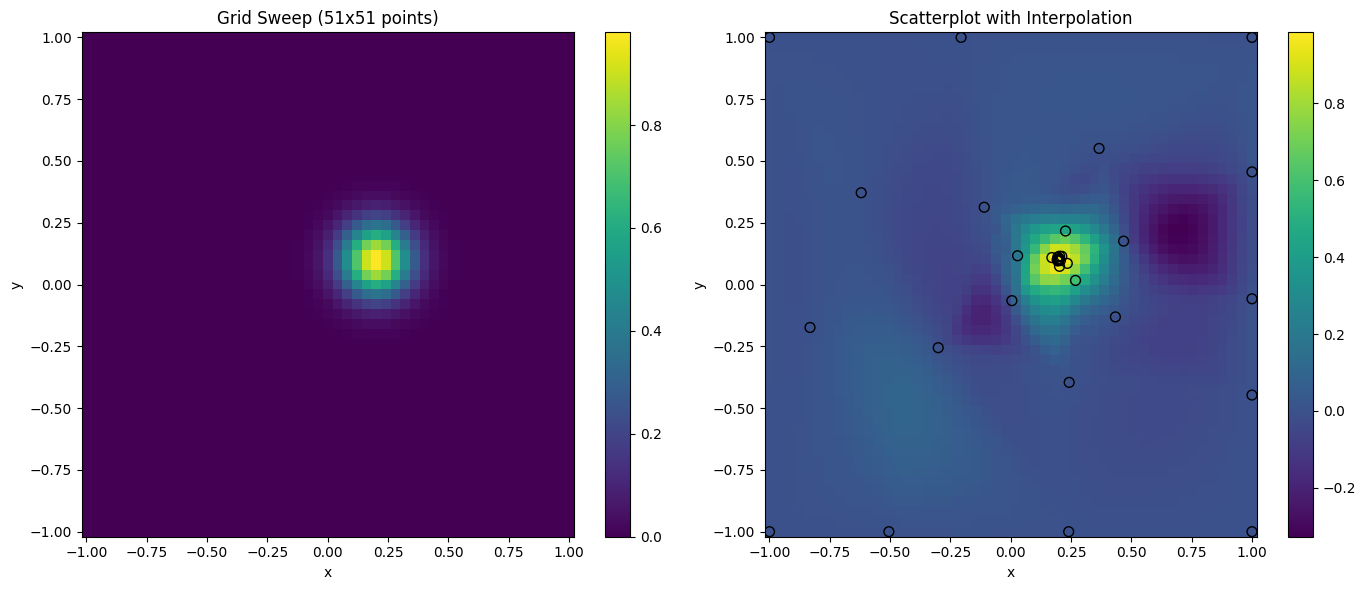

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from ax import optimize
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models

# Define the Gaussian peak function.
def gaussian_peak(x, y):
    x_peak, y_peak = 0.2, 0.1
    sigma = 0.1
    return np.exp(-((x - x_peak) ** 2 + (y - y_peak) ** 2) / (2 * sigma ** 2))

# Create a grid sweep version (51 x 51 points).
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = gaussian_peak(x_grid, y_grid)

# Number of Sobol samples for initial exploration.
num_initial_samples = 5

# Setting up the Bayesian optimizer using Ax with a custom generation strategy.
generation_strategy = GenerationStrategy(
    steps=[
        GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
        GenerationStep(model=Models.GPEI, num_trials=-1),
    ]
)

ax_client = AxClient(generation_strategy=generation_strategy)
ax_client.create_experiment(
    name="2d_gaussian_peak_optimization",
    parameters=[
        {"name": "x", "type": "range", "bounds": [-1.0, 1.0]},
        {"name": "y", "type": "range", "bounds": [-1.0, 1.0]},
    ],
    objective_name="z",
    minimize=False,  # Set True if you want to minimize the objective
)

z_samples = []
x_samples = []
y_samples = []

# Initial exploration with Sobol sampling.
for _ in range(num_initial_samples):
    params, trial_index = ax_client.get_next_trial()
    x_sample, y_sample = params['x'], params['y']
    z = gaussian_peak(x_sample, y_sample)
    x_samples.append(x_sample)
    y_samples.append(y_sample)
    z_samples.append(z)
    ax_client.complete_trial(trial_index=trial_index, raw_data=z)

# Bayesian optimization loop with convergence criteria.
epsilon = 1e-3  # Convergence threshold
num_bo_samples = 100  # Maximum number of Bayesian optimization samples
patience = 10  # Number of iterations without improvement to stop early

best_value = None
no_improvement_counter = 0

for i in range(num_bo_samples):
    params, trial_index = ax_client.get_next_trial()
    x_sample, y_sample = params['x'], params['y']
    z = gaussian_peak(x_sample, y_sample)
    x_samples.append(x_sample)
    y_samples.append(y_sample)
    z_samples.append(z)
    ax_client.complete_trial(trial_index=trial_index, raw_data=z)

    # Check for convergence based on improvement.
    if best_value is None or z > best_value + epsilon:
        best_value = z
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1

    # Stop early if no improvement for a number of iterations.
    if no_improvement_counter >= patience:
        print(f"Stopping early after {i + 1} iterations due to lack of improvement.")
        break

# Create interpolation for the scatter plot using scipy's griddata.
x_interp, y_interp = np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)
x_interp_grid, y_interp_grid = np.meshgrid(x_interp, y_interp)
z_interp = griddata((x_samples, y_samples), z_samples, (x_interp_grid, y_interp_grid), method='cubic')

# Plotting the grid sweep version.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pcolormesh for grid sweep version.
c1 = ax[0].pcolormesh(x_grid, y_grid, z_grid, shading='auto', cmap='viridis')
fig.colorbar(c1, ax=ax[0])
ax[0].set_title("Grid Sweep (51x51 points)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

# Scatter plot over griddata interpolation.
c2 = ax[1].pcolormesh(x_interp_grid, y_interp_grid, z_interp, shading='auto', cmap='viridis')
fig.colorbar(c2, ax=ax[1])
ax[1].scatter(x_samples, y_samples, edgecolor='black', facecolor='none', s=50)  # Black circles with no facevalues
ax[1].set_title("Scatterplot with Interpolation")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

plt.tight_layout()
plt.show()

# Ax.dev with full features
- Adding in exploration
- scalarizing inputs 
- converting to utility function

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from ax import optimize
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition import qNegIntegratedPosteriorVariance
import random
from typing import Tuple
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from ax.utils.common.logger import get_logger

logger = get_logger(__name__)


def bayesian_optimizer(num_initial_samples: int = 10, num_bo_samples: int = 100, epsilon: float = 1e-3, patience: int = 15, refit_every: int = 10, exploit_ratio: float = 0.9, seed: int = 1):
    """
    Bayesian optimization function that yields new points to sample.

    Args:
        num_initial_samples (int): Number of initial Sobol samples for exploration. These samples provide a broad understanding of the parameter space.
        num_bo_samples (int): Maximum number of Bayesian optimization samples to be taken after the initial exploration.
        epsilon (float): Convergence threshold. If the improvement in the objective function value is less than this threshold, it is considered as no improvement.
        patience (int): Number of iterations without improvement to allow before stopping early. Helps prevent unnecessary computation if the model is no longer improving.
        refit_every (int): Number of iterations after which the GP model is refit. Refitting frequently can improve model accuracy but is computationally expensive.
        exploit_ratio (float): Proportion of times exploitation (GPEI) is used compared to exploration (qNIPV). A higher value favors exploitation over exploration.
        seed (int): Random seed for reproducibility of the optimization process.
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    # Setting up the Bayesian optimizer using Ax with a custom generation strategy.
    # The generation strategy defines how initial exploration (using Sobol) and subsequent optimization (using GPEI) are conducted.
    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(model=Models.GPEI, num_trials=-1),
        ]
    )

    ax_client = AxClient(generation_strategy=generation_strategy)
    ax_client.create_experiment(
        name="2d_gaussian_peak_optimization",
        parameters=[
            {"name": "x", "type": "range", "bounds": [-1.0, 1.0]},
            {"name": "y", "type": "range", "bounds": [-1.0, 1.0]},
        ],
        objective_name="z",
        minimize=False,  # Set True if you want to minimize the objective
    )

    # Lists to store sampled points and their objective values.
    z_samples = []
    x_samples = []
    y_samples = []

    # Initial exploration with Sobol sampling.
    for _ in range(num_initial_samples):
        params, trial_index = ax_client.get_next_trial()
        x_sample, y_sample = params['x'], params['y']
        z = np.exp(-((x_sample - 0.2) ** 2 + (y_sample - 0.1) ** 2) / (2 * 0.1 ** 2))
        x_samples.append(x_sample)
        y_samples.append(y_sample)
        z_samples.append(z)
        ax_client.complete_trial(trial_index=trial_index, raw_data=z)
        yield x_sample, y_sample, z

    # Normalize and standardize the data.
    x_samples_normalized, y_samples_normalized, z_samples_standardized = normalize_and_standardize(x_samples, y_samples, z_samples)

    # Convert normalized and standardized inputs to tensors for model training.
    x_samples_tensor = torch.tensor(x_samples_normalized).double().reshape(-1, 1)
    y_samples_tensor = torch.tensor(y_samples_normalized).double().reshape(-1, 1)
    z_samples_tensor = torch.tensor(z_samples_standardized).double().flatten()
    x_y_samples_tensor = torch.cat([x_samples_tensor, y_samples_tensor], dim=1)

    # Define and fit the GP model.
    gp_model = SingleTaskGP(x_y_samples_tensor, z_samples_tensor.unsqueeze(-1))
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)

    # Bayesian optimization loop with convergence criteria.
    best_value = None
    no_improvement_counter = 0

    for i in range(num_bo_samples):
        # Randomly decide whether to use exploitation (GPEI) or exploration (qNIPV)
        rand_value = random.random()
        if rand_value < exploit_ratio:
            # Exploitation with GPEI
            logger.info("Using GPEI for exploitation")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
        else:
            # Exploration with qNIPV
            logger.info("Using qNIPV for exploration")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 500},
            }

        params, trial_index = ax_client.get_next_trial()
        x_sample, y_sample = params['x'], params['y']
        z = np.exp(-((x_sample - 0.2) ** 2 + (y_sample - 0.1) ** 2) / (2 * 0.1 ** 2))
        x_samples.append(x_sample)
        y_samples.append(y_sample)
        z_samples.append(z)
        ax_client.complete_trial(trial_index=trial_index, raw_data=z)
        yield x_sample, y_sample, z

        # Add new sample to training data (normalized and standardized)
        x_samples_normalized, y_samples_normalized, z_samples_standardized = normalize_and_standardize(x_samples, y_samples, z_samples)

        x_samples_tensor = torch.cat([torch.tensor(x_samples_normalized).double().reshape(-1, 1)])
        y_samples_tensor = torch.cat([torch.tensor(y_samples_normalized).double().reshape(-1, 1)])
        z_samples_tensor = torch.tensor(z_samples_standardized).double().flatten()
        x_y_samples_tensor = torch.cat([x_samples_tensor, y_samples_tensor], dim=1)

        # Refit the GP model only every `refit_every` iterations to reduce computational overhead.
        # Refitting every few iterations helps maintain model accuracy without excessive computational cost.
        if i % refit_every == 0 or i == num_bo_samples - 1:
            gp_model.set_train_data(x_y_samples_tensor, z_samples_tensor.unsqueeze(-1), strict=False)
            fit_gpytorch_model(mll)

        # Check for convergence based on improvement only during exploitation.
        if rand_value < exploit_ratio:  # Only check for convergence during exploitation
            if best_value is None or z > best_value + epsilon:
                best_value = z
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1

        # Stop early if no improvement for a number of iterations.
        if no_improvement_counter >= patience:
            print(f"Stopping early after {i + 1} iterations due to lack of improvement.")
            break

def normalize_and_standardize(x_samples, y_samples, z_samples):
    """
    Helper function to normalize and standardize the samples.

    Args:
        x_samples (list): List of x coordinates of samples.
        y_samples (list): List of y coordinates of samples.
        z_samples (list): List of objective values for samples.

    Returns:
        tuple: Normalized x samples, normalized y samples, standardized z samples.

    Explanation:
    - Normalization of x and y: Input features (x and y) are normalized to the unit cube to ensure that the optimization operates in a well-defined and bounded search space. This improves numerical stability and the performance of the Gaussian Process model.
    - Standardization of z: The objective values (z) are standardized to have zero mean and unit variance. This helps the model in efficiently learning the objective function by preventing scale differences from dominating the optimization process.
    """
    x_samples_np = np.array(x_samples)
    y_samples_np = np.array(y_samples)
    z_samples_np = np.array(z_samples)

    # Normalize input data to the unit cube for model training.
    x_min, x_max = x_samples_np.min(), x_samples_np.max()
    y_min, y_max = y_samples_np.min(), y_samples_np.max()

    x_samples_normalized = (x_samples_np - x_min) / (x_max - x_min)
    y_samples_normalized = (y_samples_np - y_min) / (y_max - y_min)

    # Standardize output data (z) for model training.
    z_mean, z_std = z_samples_np.mean(), z_samples_np.std()
    z_samples_standardized = (z_samples_np - z_mean) / z_std

    return x_samples_normalized, y_samples_normalized, z_samples_standardized

## Example use case with bayesian_optimizer()

[INFO 11-19 00:48:28] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 11-19 00:48:28] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-19 00:48:28] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter y. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-19 00:48:28] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x', parameter_type=FLOAT, range=[-1.0, 1.0]), RangeParameter(name='y', parameter_type=FLOAT, range=[-1.0, 1.0])], parameter_constraints=[]).
[INFO 11-19 00:48:28] a

Stopping early after 29 iterations due to lack of improvement.


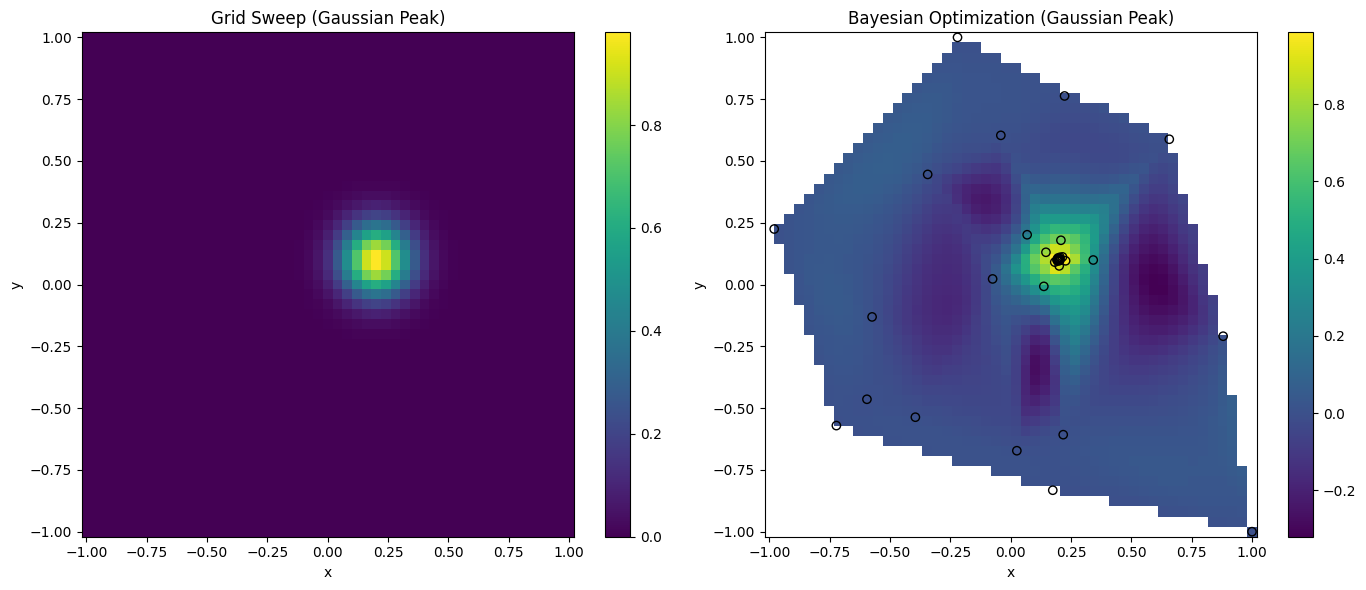

In [67]:
# Create a grid sweep version (51 x 51 points).
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = np.exp(-((x_grid - 0.2) ** 2 + (y_grid - 0.1) ** 2) / (2 * 0.1 ** 2))

# Use the Bayesian optimizer to get new points.
x_samples, y_samples, z_samples = [], [], []
for x_sample, y_sample, z in bayesian_optimizer():
    x_samples.append(x_sample)
    y_samples.append(y_sample)
    z_samples.append(z)

# Create interpolation for the scatter plot using scipy's griddata.
x_interp = np.linspace(-1, 1, 50)
y_interp = np.linspace(-1, 1, 50)
x_interp_grid, y_interp_grid = np.meshgrid(x_interp, y_interp)
z_interp = griddata((x_samples, y_samples), z_samples, (x_interp_grid, y_interp_grid), method='cubic')

# Plotting the grid sweep version.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pcolormesh for grid sweep version.
c1 = ax[0].pcolormesh(x_grid, y_grid, z_grid, shading='auto', cmap='viridis')
ax[0].set_title("Grid Sweep (Gaussian Peak)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
fig.colorbar(c1, ax=ax[0])

# Scatter plot with interpolation for Bayesian optimization samples.
c2 = ax[1].pcolormesh(x_interp_grid, y_interp_grid, z_interp, shading='auto', cmap='viridis')
ax[1].scatter(x_samples, y_samples, edgecolor='black', facecolor='none')
ax[1].set_title("Bayesian Optimization (Gaussian Peak)")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
fig.colorbar(c2, ax=ax[1])

plt.tight_layout()
plt.show()